In [1]:
import numpy as np
from skimage.feature import hog
from tqdm import tqdm
import pickle

In [12]:
def unpickle(file):
  dict = pickle.load(file, encoding='bytes')
  return dict

In [15]:
def load_cifar_batch(filename):
    #returns features, labels of a batchfile
    with open(filename, 'rb') as file:
        batch_data = unpickle(file)

    pixels = batch_data[b'data']
    labels = batch_data[b'labels']

    #3072---->3,32,32---->32,32,3
    pixels = pixels.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return pixels, labels

In [16]:
def load_cifar_data():
  #returns X_train, y_train, X_test, y_test
  X_train, y_train = [], []
  for i in range(1, 6):
      pixels, labels = load_cifar_batch(f'data_batch_{i}')
      X_train.append(pixels)
      y_train += labels

  X_train = np.concatenate(X_train)
  y_train = np.array(y_train)

  X_test, y_test = load_cifar_batch('test_batch')
  X_test, y_test = np.array(X_test), np.array(y_test)

  print(f"shape of train set: {X_train.shape}")
  print(f"shape of test set: {X_test.shape}")

  return X_train, y_train, X_test, y_test

In [17]:
X_train, y_train, X_test, y_test = load_cifar_data()

shape of train set: (50000, 32, 32, 3)
shape of test set: (10000, 32, 32, 3)


In [14]:
def compute_hog(img):

  #creating hog features
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, channel_axis=-1)
  return fd

In [13]:
def hog_features(data):
  X_train_hog = []
  l = len(data)
  for i in tqdm(range(l)):
    X = compute_hog(data[i])
    X_train_hog.append(X)
  X_train_hog = np.array(X_train_hog)
  return X_train_hog

In [3]:
from sklearn.decomposition import PCA

In [21]:
x_train_flat = X_train.reshape(-1,3072)
pca = PCA(0.99)
pca.fit(x_train_flat)
PCA(copy = True, iterated_power = 'auto', n_components = 0.99, random_state = None, svd_solver = 'auto', tol = 0.0, whiten = False)
pca.n_components_

np.int64(658)

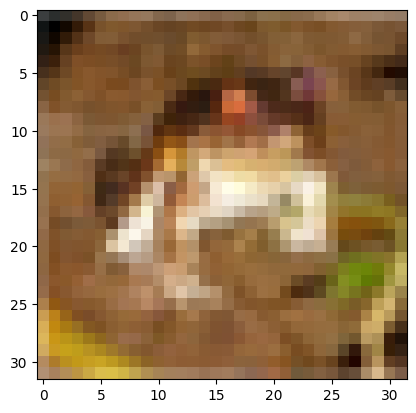

In [22]:
import matplotlib.pyplot as plt
image = X_train[0]
plt.imshow(image)
plt.show()

In [26]:
pca = PCA(658)
a = pca.fit_transform(x_train_flat)
a_inv = pca.inverse_transform(a)

In [27]:
a.shape

(50000, 658)

In [28]:
a_inv.shape

(50000, 3072)

In [20]:
def normalize_image(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return img.astype(np.uint8)

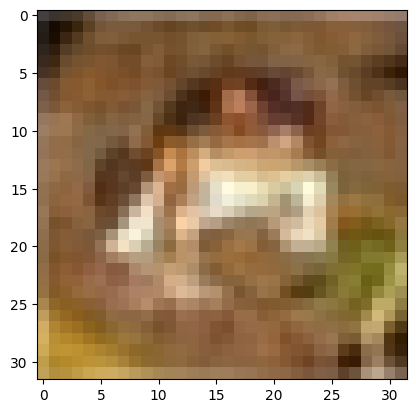

[ 59  62  63 ... 123  92  72]


array([ 68.61949403,  63.73888939,  62.57702582, ..., 120.73856569,
       100.62428821,  80.26556119])

In [36]:
image_c = a_inv[0].reshape(32,32,3)
image_c = normalize_image(image_c)
plt.imshow(image_c)
plt.show()
print(x_train_flat[0])
a_inv[0]

In [ ]:
#def pca_hog(data):


In [ ]:
#def hog_pca(data):

In [43]:
with open('FeaturesPCA.pkl', 'wb') as f:
    pickle.dump(a, f)

In [48]:
feat_hog = hog_features(X_train)
print(feat_hog.shape)

with open('FeaturesHoG.pkl', 'wb') as f:
    pickle.dump(feat_hog, f)

100%|██████████| 50000/50000 [02:47<00:00, 297.83it/s]


(50000, 324)


In [2]:
with open('FeaturesHoG.pkl', 'rb') as f:
    feat_hog = pickle.load(f)

In [4]:
pca = PCA(0.99)
pca.fit(feat_hog)
PCA(copy = True, iterated_power = 'auto', n_components = 0.99, random_state = None, svd_solver = 'auto', tol = 0.0, whiten = False)
pca.n_components_

np.int64(170)

In [41]:
pca = PCA(170)
a = pca.fit_transform(feat_hog)
a.shape

(50000, 170)

In [7]:
with open('FeaturesHoG_PCA.pkl', 'wb') as f:
    pickle.dump(a, f)

In [29]:
x_train_flat = X_train.reshape(-1,3072)
pca_ = PCA(658)
feat_pca = pca_.fit_transform(x_train_flat)
feat_inv_pca = pca_.inverse_transform(feat_pca)

In [30]:
feat_inv_pca = feat_inv_pca.reshape(-1,32,32,3)
for image in feat_inv_pca:
  image = normalize_image(image)

In [33]:
feat_inv_pca = feat_inv_pca.astype(np.uint8)
print(feat_inv_pca.shape)

feat_pca_hog = hog_features(feat_inv_pca)
print(feat_pca_hog.shape)

with open('FeaturesPCA_HoG.pkl', 'wb') as f:
    pickle.dump(feat_pca_hog, f)

(50000, 32, 32, 3)


100%|██████████| 50000/50000 [02:42<00:00, 308.49it/s]


(50000, 324)


In [34]:
feat_hog_test = hog_features(X_test)
print(feat_hog_test.shape)

with open('TestHoG.pkl', 'wb') as f:
    pickle.dump(feat_hog_test, f)

100%|██████████| 10000/10000 [00:33<00:00, 296.19it/s]

(10000, 324)


In [38]:
x_test_flat = X_test.reshape(-1,3072)
feat_pca_test = pca_.transform(x_test_flat)
feat_inv_pca_test = pca_.inverse_transform(feat_inv_pca_test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 658 is different from 3072)

In [36]:
feat_pca_test.shape

(10000, 658)

In [37]:
with open('TestPCA.pkl', 'wb') as f:
    pickle.dump(feat_pca_test, f)

In [39]:
feat_inv_pca_test = pca_.inverse_transform(feat_pca_test)
feat_inv_pca_test = feat_inv_pca_test.reshape(-1,32,32,3)
for image in feat_inv_pca_test:
  image = normalize_image(image)

feat_inv_pca_test = feat_inv_pca_test.astype(np.uint8)
print(feat_inv_pca_test.shape)

feat_pca_hog_test = hog_features(feat_inv_pca_test)
print(feat_pca_hog_test.shape)

with open('TestPCA_HoG.pkl', 'wb') as f:
    pickle.dump(feat_pca_hog_test, f)

(10000, 32, 32, 3)


100%|██████████| 10000/10000 [00:31<00:00, 315.97it/s]


(10000, 324)


In [42]:
feat_hog_test = pca.transform(feat_hog_test)
feat_hog_test.shape

(10000, 170)

In [43]:
with open('TestHoG_PCA.pkl', 'wb') as f:
    pickle.dump(feat_hog_test, f)